# 50 оттенков градиентного спуска 

В этом задании вам предстоит реализовать линейный классификатор и натренировать его, используя различные модификации градинетного спуска. Тетрадка позаимствована с [шадовского курса по нейронкам.](https://github.com/yandexdataschool/Practical_DL/blob/master/week01_backprop/adapdive_sgd/adaptive_sgd.ipynb)

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

## Генерация выборки

Для наших целей будем использовать искуственно сгенерированные данные.

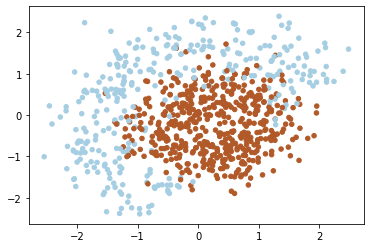

In [2]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

### [1] Варка фичей

Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [3]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """
    n_samples = X.shape[0]
    return np.column_stack((X, X[:, 0]**2, X[:, 1]**2, X[:, 0]*X[:, 1], np.ones(n_samples)))


In [4]:
X_expanded = expand(X)
df_expanded = pd.DataFrame(np.column_stack((X_expanded, y)), columns=['x0', 'x1', 'x0^2', 'x1^2', 'x0*x1', '1', 'target'])

print(df_expanded.shape)
df_expanded.head()

(826, 7)


,x0,x1,x0^2,x1^2,x0*x1,1,target
0,1.207981,0.084499,1.459217,0.007140,0.102074,1.0,1.0
1,0.761218,0.725109,0.579453,0.525783,0.551966,1.0,1.0
2,0.552562,0.519373,0.305325,0.269748,0.286986,1.0,1.0
3,-0.582708,0.267048,0.339548,0.071315,-0.155611,1.0,1.0
4,2.102288,1.633871,4.419616,2.669534,3.434868,1.0,0.0


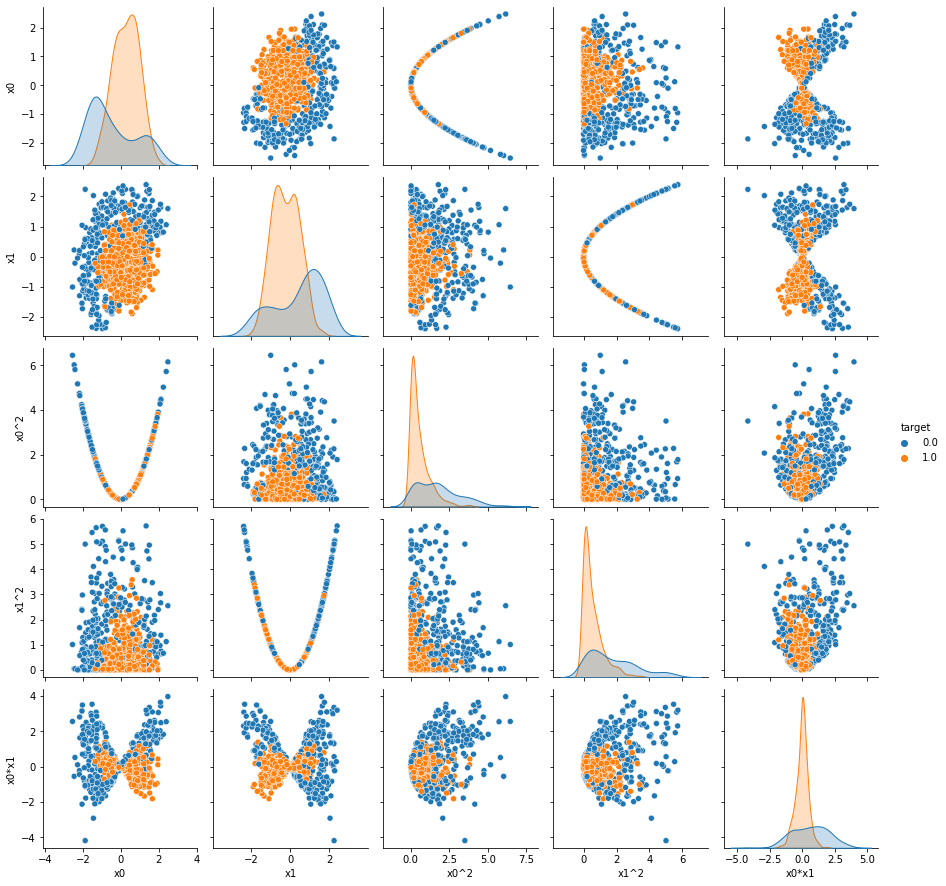

In [6]:
cols = df_expanded.columns.difference(['1'], sort=False)
sns.pairplot(df_expanded[cols], vars=cols[:-1], hue='target');

### [3] Логистическая регрессия 

Для классификации будем использовать логистическую регрессию. 

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [7]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
    
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей
    """
    probs = 1 / (1 + np.exp(-X.dot(w)))
    return probs

In [8]:
w = np.random.random(6)
probs = probability(X_expanded, w)
print(probs[:5])

[0.90843641 0.90105878 0.81649951 0.62458894 0.99989778]


Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [9]:
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу весов, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, расчитанное по формуле выше.
    """
    probs = probability(X, w)
    n = X.shape[0]
    loss_func = -1 / n * np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))
    return loss_func

In [10]:
loss = compute_loss(X_expanded, y, w)
print(loss)

1.4675548296829906


Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = ...$$

Тут обойдёмся даже без матричного дифириенцирования. А вот в следущий раз его не миновать...

In [11]:
def compute_grad(X, y, w):
    """
    Нахоит значение градиента.
    """
    n = X.shape[0]
    probs = probability(X, w)
    loss_grad = 1 / n * (probs - y).dot(X)
    return loss_grad


In [12]:
loss_grad = compute_grad(X_expanded, y, w)
print(loss_grad)

[-0.14933102  0.19601675  0.56856743  0.55711187  0.24007786  0.18843125]


Функция ниже предназначена для визуализации процесса обучения. 

In [13]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

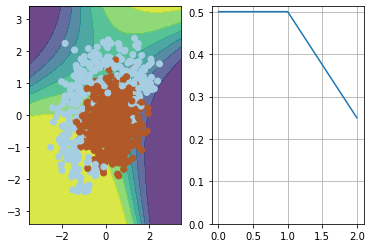

In [14]:
# убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Обучение

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

### [2] Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



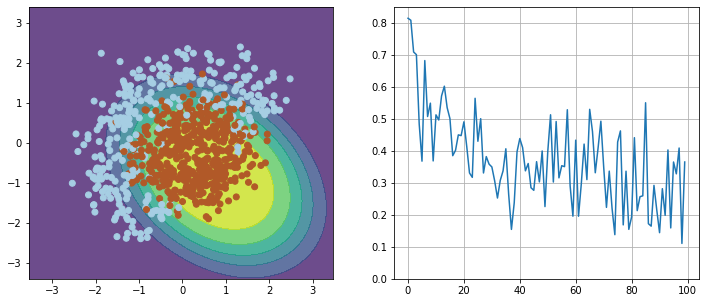

<Figure size 432x288 with 0 Axes>

In [25]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded[ind], y[ind], w)
#     visualize(X_expanded[ind], y[ind], w, loss)
    
    w = w - eta * compute_grad(X_expanded[ind], y[ind], w)
    
visualize(X, y, w, loss)
plt.clf()

### [2] Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


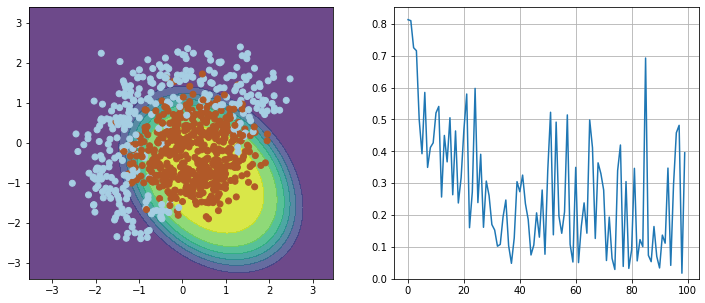

<Figure size 432x288 with 0 Axes>

In [24]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 
alpha = 0.9 
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded[ind], y[ind], w)
#     visualize(X[ind], y[ind], w, loss)
    
    nu = alpha * nu + eta * compute_grad(X_expanded[ind], y[ind], w)
    w = w - nu
    
visualize(X, y, w, loss)
plt.clf()

### [2] RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

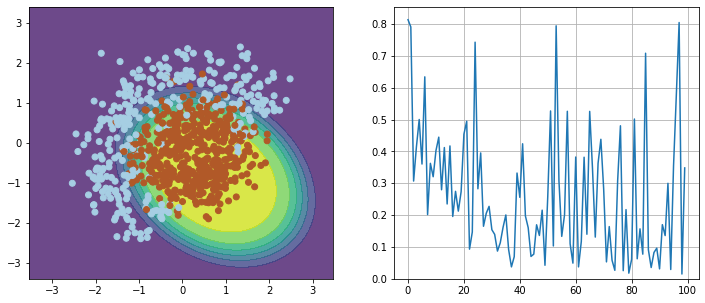

<Figure size 432x288 with 0 Axes>

In [23]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
G = 0
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded[ind], y[ind], w)
#     visualize(X[ind], y[ind], w, loss)
    
    grad = compute_grad(X_expanded[ind], y[ind], w)
    G = alpha * G + (1 - alpha) * grad**2
    w = w - (eta / np.power(G + eps, 0.5)) * grad
    
    
visualize(X, y, w, loss)
plt.clf()

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam? 

### [2] За каждую адекватную вариацию

Если понравилось реализовывать свои градиентные спуски и ты находишься от них под глубоким впечатлением, я могу накинуть два дополнительных балла за реализацию каждой новой адекватной вариации. 

## Adagrad

$$ G_t^j = \sum_{i=1}^t{g_{ij}^2} $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

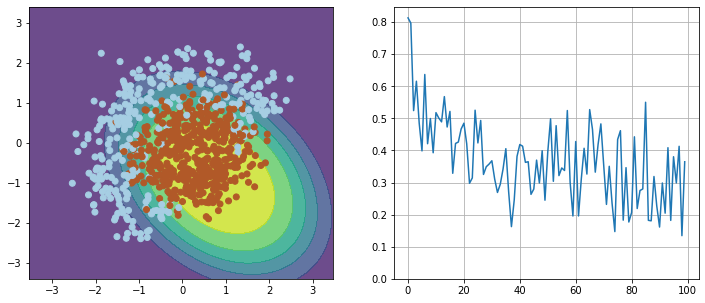

<Figure size 432x288 with 0 Axes>

In [22]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
G = 0
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded[ind], y[ind], w)
#     visualize(X[ind], y[ind], w, loss)
    
    grad = compute_grad(X_expanded[ind], y[ind], w)
    G = G + grad ** 2
    w = w - (eta / np.power(G + eps, 0.5)) * grad
    
    
visualize(X, y, w, loss)
plt.clf()

## NesterovAG

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t - \alpha \nu_{t-1}, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$

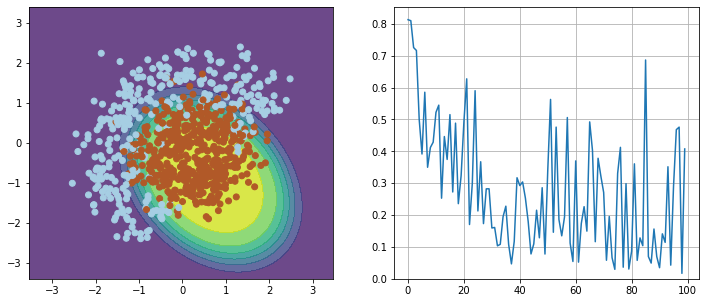

<Figure size 432x288 with 0 Axes>

In [21]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 
alpha = 0.9 
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded[ind], y[ind], w)
#     visualize(X[ind], y[ind], w, loss)
    
    nu = alpha * nu + eta * compute_grad(X_expanded[ind] - alpha * nu, y[ind], w)
    w = w - nu
    
visualize(X, y, w, loss)
plt.clf()

## Adam

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) \cdot \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j})$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) \cdot (\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}))^2$$
$$\hat m_t = \dfrac{m_t}{1 - \beta_1^t}$$
$$\hat v_t = \dfrac{v_t}{1 - \beta_2^t}$$
$$w_t = w_{t-1} - \dfrac{\eta \cdot \hat m_t}{\sqrt{\hat v_t} + \epsilon}$$

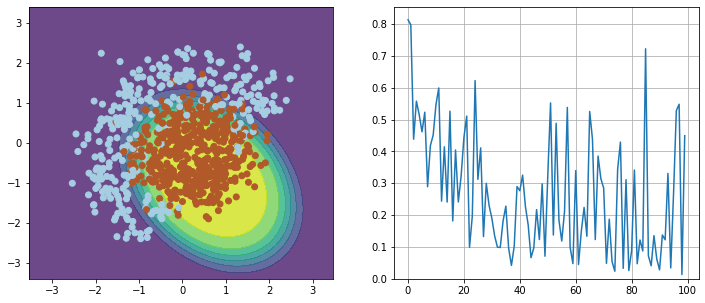

<Figure size 432x288 with 0 Axes>

In [20]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 
beta1 = 0.9 
beta2 = 0.999
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
m, v = 0, 0

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded[ind], y[ind], w)
#     visualize(X[ind], y[ind], w, loss)
    
    grad = compute_grad(X_expanded[ind], y[ind], w)
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * grad**2
    
    m_hat = m / (1 - beta1**(i + 1))
    v_hat = v / (1 - beta2**(i + 1))
    
    w = w - (eta / (np.power(v_hat, 0.5) + eps)) * m_hat
    
    
visualize(X, y, w, loss)
plt.clf()

**batch_size = 400**

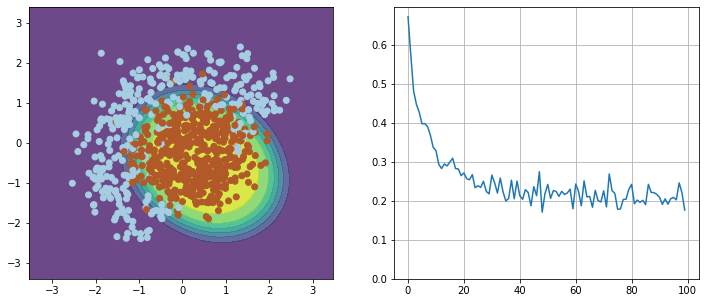

<Figure size 432x288 with 0 Axes>

In [29]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 
beta1 = 0.9 
beta2 = 0.999
eps = 1e-8

n_iter = 100
batch_size = 400
loss = np.zeros(n_iter)
m, v = 0, 0

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded[ind], y[ind], w)
#     visualize(X[ind], y[ind], w, loss)
    
    grad = compute_grad(X_expanded[ind], y[ind], w)
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * grad**2
    
    m_hat = m / (1 - beta1**(i + 1))
    v_hat = v / (1 - beta2**(i + 1))
    
    w = w - (eta / (np.power(v_hat, 0.5) + eps)) * m_hat
    
    
visualize(X, y, w, loss)
plt.clf()